# Import Libraries

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col,desc,count
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

import seaborn as sns
import pandas as pd

# Create Application

In [2]:
#Create SparkSession
spark = SparkSession.builder.appName('Flight_delay').getOrCreate()

22/12/05 15:00:46 WARN Utils: Your hostname, Jaminurs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.4 instead (on interface en0)
22/12/05 15:00:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/05 15:00:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Read all flight Data
<br>
From year 1988-2008

In [3]:
Flight_Spark_frame  = spark.read.option('recursiveFileLookup','True').option("header", "true")\
                        .csv("dataverse_files/*")
Flight_Spark_frame.printSchema()
# .option("inferSchema", "true") # this enforce data type 

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

In [4]:
Flight_Spark_frame.select('TailNum','FlightNum','Origin','Dest').show()

+-------+---------+------+----+
|TailNum|FlightNum|Origin|Dest|
+-------+---------+------+----+
|   N351|     2891|   SMF| ONT|
|   N370|      462|   SMF| PDX|
|   N685|     1229|   SMF| PDX|
|   N364|     1355|   SMF| PDX|
|   N480|     2278|   SMF| PDX|
| N611SW|     2386|   SMF| PDX|
|   N482|      409|   SMF| PHX|
| N749SW|     1131|   SMF| PHX|
|   N451|     1212|   SMF| PHX|
| N630WN|     2456|   SMF| PHX|
|   N493|     2575|   SMF| PHX|
| N733SW|     2608|   SMF| PHX|
|   N348|      139|   SMF| SAN|
|   N358|      747|   SMF| SAN|
|   N413|      933|   SMF| SAN|
|   N416|     1054|   SMF| SAN|
| N383SW|     1106|   SMF| SAN|
| N316SW|     1554|   SMF| SAN|
| N691WN|     1604|   SMF| SAN|
| N308SW|     1975|   SMF| SAN|
+-------+---------+------+----+
only showing top 20 rows



# Read Other tables
<br>
1: Carrier Table <br>
2: Plane Data <br>
3: Airport Data

In [5]:
carrier_Spark_frame  = spark.read.option("header", "true").csv("carriers.csv")
plane_Spark_frame  = spark.read.option("header", "true").csv("plane-data.csv")
airport_Spark_frame  = spark.read.option("header", "true").csv("airports.csv")

# Rename the conflicting column

In [6]:
plane_Spark_frame = plane_Spark_frame.withColumnRenamed("year","Pyear")
carrier_Spark_frame.printSchema()
plane_Spark_frame.printSchema()
airport_Spark_frame.printSchema()

root
 |-- tailnum: string (nullable = true)
 |-- type: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- issue_date: string (nullable = true)
 |-- model: string (nullable = true)
 |-- status: string (nullable = true)
 |-- aircraft_type: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- PYear: string (nullable = true)

root
 |-- Code: string (nullable = true)
 |-- Description: string (nullable = true)

root
 |-- tailnum: string (nullable = true)
 |-- type: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- issue_date: string (nullable = true)
 |-- model: string (nullable = true)
 |-- status: string (nullable = true)
 |-- aircraft_type: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- year: string (nullable = true)

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullabl

# Data Preprocessing after reading
<br>
change the type of delays from string to integer

In [7]:
Flight_Spark_frame = Flight_Spark_frame.withColumn("WeatherDelay",col("WeatherDelay").cast(IntegerType())) \
    .withColumn("NASDelay",col("NASDelay").cast(IntegerType())) \
    .withColumn("SecurityDelay",col("SecurityDelay").cast(IntegerType()))\
    .withColumn("LateAircraftDelay",col("LateAircraftDelay").cast(IntegerType()))\
    .withColumn("CarrierDelay",col("CarrierDelay").cast(IntegerType()))\
    .withColumn("ArrDelay",col("ArrDelay").cast(IntegerType()))\
    .withColumn("DepDelay",col("DepDelay").cast(IntegerType()))
# RDD.printSchema()

In [8]:
Flight_Spark_frame.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDela

1. Merging Year Month Arrival time <br>
2. Merging Year month Actual Arrival time <br>
3. Merging Year month Departure time <br>
4. Merging Year month Actual Departure time <br>


In [9]:
Flight_Spark_frame = Flight_Spark_frame.withColumn("A_Dept_D_time",\
        F.expr("make_timestamp(Year, Month, DayofMonth, substr(DepTime,1,2), substr(DepTime,3,2), 0)"))\
                    .withColumn("S_Dept_D_time",\
        F.expr("make_timestamp(Year, Month, DayofMonth, substr(CRSDepTime,1,2), substr(CRSDepTime,3,2), 0)"))\
                    .withColumn("A_Arr_D_time",\
        F.expr("make_timestamp(Year, Month, DayofMonth, substr(ArrTime,1,2), substr(ArrTime,3,2), 0)"))\
                    .withColumn("S_Arr_D_time",\
        F.expr("make_timestamp(Year, Month, DayofMonth, substr(CRSArrTime,1,2), substr(CRSArrTime,3,2), 0)"))


# Correlation Analysis of different delays

In [10]:
vector_col = "corr_features"
Flight_Spark_frame_Filter = Flight_Spark_frame.select(col('CarrierDelay'),
 col('WeatherDelay'),col('NASDelay'),
 col('ArrDelay'),col('DepDelay'),
 col('SecurityDelay'),col('LateAircraftDelay'))
# RDD_Filter.na.fill(value=0).show()
assembler = VectorAssembler(inputCols=Flight_Spark_frame_Filter.columns, outputCol=vector_col)
df_vector = assembler.setHandleInvalid("skip").transform(Flight_Spark_frame_Filter).select(vector_col)
# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)


22/12/05 15:03:17 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/05 15:03:17 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


# Correlation Plot

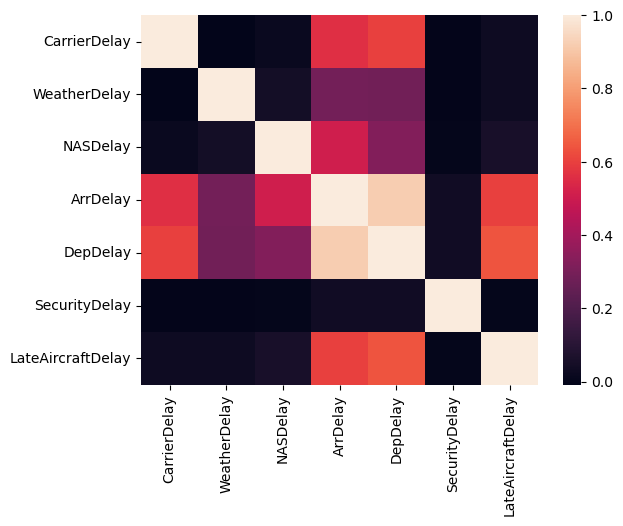

In [11]:
corr_matrix = matrix.collect()[0][0].toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = Flight_Spark_frame_Filter.columns, 
                              index=Flight_Spark_frame_Filter.columns) 

sns.heatmap(corr_matrix_df, 
        xticklabels=corr_matrix_df.columns,
        yticklabels=corr_matrix_df.columns)
plt.savefig('correlation.png', bbox_inches='tight')
plt.show()

# Some key Insights and Visualization 
<br>
total count 

In [24]:
Flight_Spark_frame.count()

118914458

count the cancelled flight
<br>
(A = carrier, B = weather, C = NAS, D = security)

In [12]:
Flight_Spark_frame.groupBy("CancellationCode").count().orderBy("count", ascending = False).show()


+----------------+--------+
|CancellationCode|   count|
+----------------+--------+
|              NA|83844440|
|            null|34408304|
|               A|  289717|
|               B|  237894|
|               C|  133508|
|               D|     595|
+----------------+--------+



Flight cancelled count plot

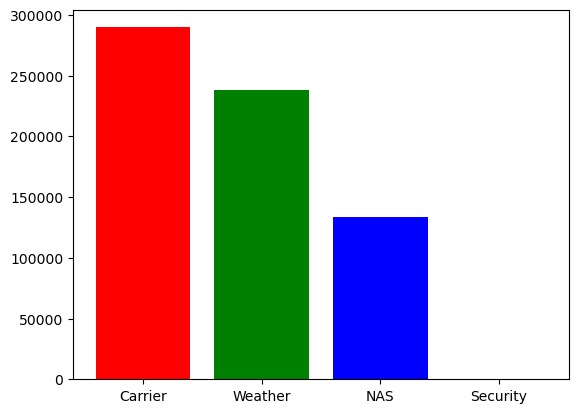

In [13]:
plt.bar(["Carrier","Weather","NAS","Security"],[289717,237894,133508,595],color = ['red','green','blue','orange'])
plt.savefig('cancellation.png', bbox_inches='tight')
plt.show()

Unique Carrier

Per Carrier Flight Count
https://learn.microsoft.com/en-us/azure/synapse-analytics/spark/apache-spark-data-visualization-tutorial

In [27]:
Per_carrier_flight = Flight_Spark_frame.groupBy("UniqueCarrier").count().orderBy("count", ascending = False)

Sampling technique for distribution plot

In [28]:
Per_carrier_flight_sampled = Per_carrier_flight.sample(True, 0.001, seed=1234)
Per_carrier_flight_df = Per_carrier_flight_sampled.toPandas()

# Distribution of delays for a carrier

## Spark SQL to look into flight data by Carrier "FL"

In [29]:
Flight_Spark_frame.createOrReplaceTempView("Flight_Data")
FL_carrier = spark.sql("SELECT * from Flight_Data where UniqueCarrier='FL' ")
#RDD.filter(RDD.UniqueCarrier == 'FL').collect()
# Where year >1 < 4

## Sample a Small fragement of the data 

In [30]:
FL_carrier_sampled = FL_carrier.sample(True, 0.001, seed=1234)
FL_carrier_sampled_df = FL_carrier_sampled.toPandas()

/Users/jaminurislam/opt/anaconda3/envs/big_data/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/Users/jaminurislam/opt/anaconda3/envs/big_data/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/Users/jaminurislam/opt/anaconda3/envs/big_data/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/Users/jaminurislam/opt/anaconda3/envs/big_data/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: F

## Arrival delay distribution

/var/folders/k3/yr6xqkcd6dx_w09lmqq7y7h80000gn/T/ipykernel_43703/2609835248.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(FL_carrier_sampled_df['ArrDelay'])


<AxesSubplot:xlabel='ArrDelay', ylabel='Density'>

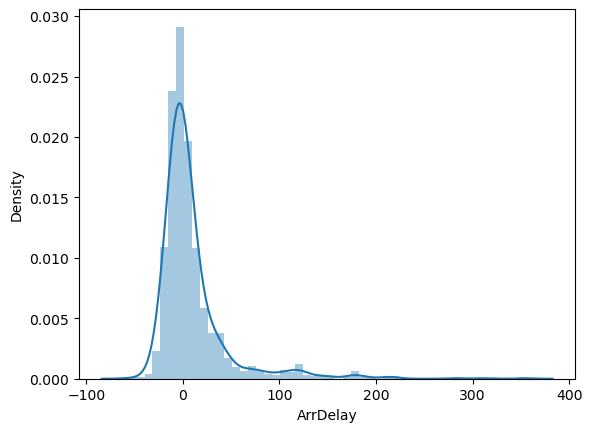

In [31]:
sns.distplot(FL_carrier_sampled_df['ArrDelay'])

## Departure delay distribution

/var/folders/k3/yr6xqkcd6dx_w09lmqq7y7h80000gn/T/ipykernel_43703/3915417223.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(FL_carrier_sampled_df['DepDelay'])


<AxesSubplot:xlabel='DepDelay', ylabel='Density'>

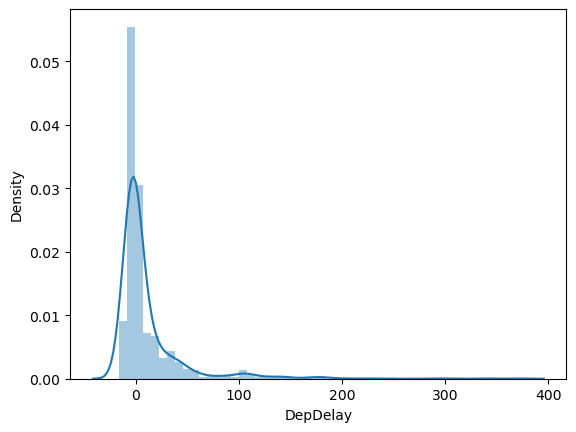

In [32]:
sns.distplot(FL_carrier_sampled_df['DepDelay'])

## Nas Delay Distribtion

/var/folders/k3/yr6xqkcd6dx_w09lmqq7y7h80000gn/T/ipykernel_43703/2149994368.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(FL_carrier_sampled_df['NASDelay'])


<AxesSubplot:xlabel='NASDelay', ylabel='Density'>

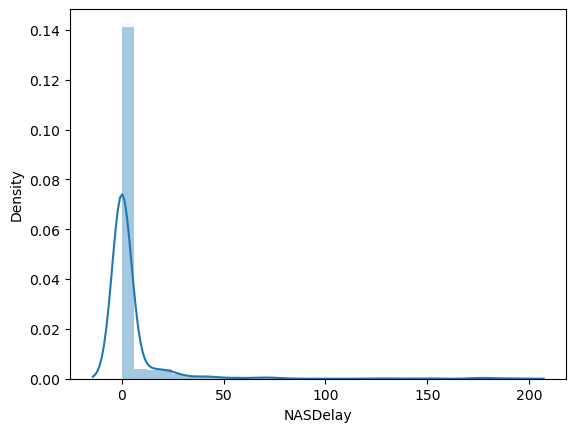

In [33]:
sns.distplot(FL_carrier_sampled_df['NASDelay'])

## Weather delay distribution

/var/folders/k3/yr6xqkcd6dx_w09lmqq7y7h80000gn/T/ipykernel_43703/1058642491.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(FL_carrier_sampled_df['WeatherDelay'])


<AxesSubplot:xlabel='WeatherDelay', ylabel='Density'>

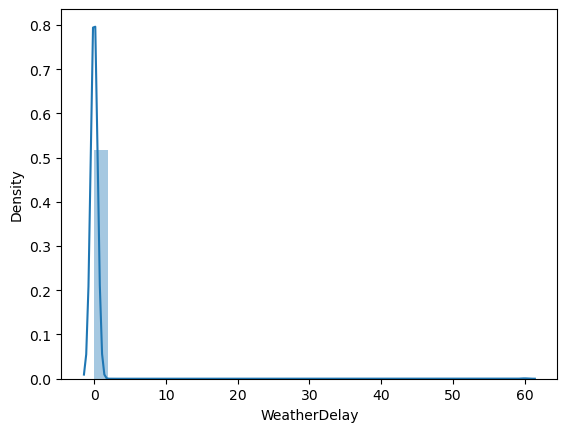

In [34]:
sns.distplot(FL_carrier_sampled_df['WeatherDelay'])

In [35]:
# sns.distplot(FL_carrier_sampled_df['SecurityDelay'])
# sns.distplot(FL_carrier_sampled_df['CarrierDelay'])
# sns.distplot(FL_carrier_sampled_df['SecurityDelay'])
# sns.distplot(FL_carrier_sampled_df['LateAircraftDelay'])

# Queries on flight data 

## Aggregate Arrival delay by carrier
<br>
Some delays can be negative as some flight can arrive early as well. 

In [36]:
# RDD.groupby('UniqueCarrier').agg({'ArrDelay': 'min'}).show()
Flight_Spark_frame.groupby('UniqueCarrier').agg(F.min('ArrDelay'),
                              F.max('ArrDelay'),
                              F.sum('ArrDelay'), 
                              F.mean('ArrDelay').alias("mean_delay"),
                              F.count('ArrDelay')).sort(desc("mean_delay")).show()

+-------------+-------------+-------------+-------------+------------------+---------------+
|UniqueCarrier|min(ArrDelay)|max(ArrDelay)|sum(ArrDelay)|        mean_delay|count(ArrDelay)|
+-------------+-------------+-------------+-------------+------------------+---------------+
|           YV|         -129|          715|      7582847|11.532461271257844|         657522|
|           EV|         -978|         1187|     15954182|10.927185121006545|        1460045|
|           PI|         -412|         1381|      9022518|10.464421039446352|         862209|
|           FL|          -86|          975|     10430611| 9.691075349039451|        1076311|
|           B6|         -105|         1392|      6246314| 9.276005963907666|         673384|
|           PS|          -60|         1033|       762188| 9.261881326479774|          82293|
|           XE|         -157|          939|     18444549| 8.947188709531112|        2061491|
|           9E|          -57|         1942|      2886663| 8.6385395064

## Aggregate Departure delay by carrier
<br>
Some delays can be negative as the data might contains noise however for our analysis we ignored negative delays 

In [34]:
# RDD.groupby('UniqueCarrier').agg({'ArrDelay': 'min'}).show()
Flight_Spark_frame.groupby('UniqueCarrier').agg(F.min('DepDelay'),
                              F.max('DepDelay'),
                              F.sum('DepDelay'), 
                              F.mean('DepDelay').alias("mean_delay"),
                              F.count('DepDelay')).sort(desc("mean_delay")).show()

+-------------+-------------+-------------+-------------+------------------+---------------+
|UniqueCarrier|min(DepDelay)|max(DepDelay)|sum(DepDelay)|        mean_delay|count(DepDelay)|
+-------------+-------------+-------------+-------------+------------------+---------------+
|           EV|         -990|         1200|     20251178|13.842378317192805|        1462984|
|           YV|          -92|          715|      8776068|13.320666453157182|         658831|
|           B6|        -1200|         1048|      7391890|10.938793932667407|         675750|
|           FL|          -62|         1345|     11304974|10.479318940033686|        1078789|
|           9E|          -47|         1956|      3292021| 9.821826872012746|         335174|
|           DH|         -810|         1050|      6448841| 9.612639389688926|         670871|
|           UA|         -780|         1437|    121979152| 9.589739175048706|       12719757|
|           PI|          -20|         1418|      8270140| 9.5603360279

## Unique Carriers with most arrival delays 

In [37]:
Flight_Spark_frame.select("UniqueCarrier","ArrDelay").filter(Flight_Spark_frame["ArrDelay"]>1).\
groupBy("UniqueCarrier").count().orderBy("count", ascending = False).show()

+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           DL|8146399|
|           US|6287198|
|           WN|6215522|
|           AA|6184853|
|           UA|5827008|
|           NW|4183263|
|           CO|3507050|
|           HP|1834668|
|           TW|1710340|
|           MQ|1466108|
|           AS|1421703|
|           OO|1035925|
|           XE| 876436|
|           EV| 672932|
|           PI| 549511|
|           OH| 535712|
|           FL| 472406|
|           EA| 401460|
|           B6| 293145|
|           YV| 274129|
+-------------+-------+
only showing top 20 rows



## Unique Carriers with most departure delays  

In [35]:
Flight_Spark_frame.select("UniqueCarrier","DepDelay").filter(Flight_Spark_frame["DepDelay"]>1).\
groupBy("UniqueCarrier").count().orderBy("count", ascending = False).show()

+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           DL|6938839|
|           US|5788996|
|           WN|5711440|
|           UA|5150444|
|           AA|4948643|
|           NW|2821979|
|           CO|2604443|
|           HP|1303638|
|           TW|1204275|
|           MQ|1200847|
|           AS| 954471|
|           OO| 841991|
|           XE| 610333|
|           EV| 589857|
|           PI| 488605|
|           OH| 386569|
|           FL| 382747|
|           B6| 272968|
|           YV| 213224|
|           EA| 209610|
+-------------+-------+
only showing top 20 rows



# Data Integration

## Merge the flight data with plane data

In [14]:
plane_flight_data = Flight_Spark_frame.join(plane_Spark_frame,"TailNum","inner")

Merge the airport data for two cases arrival and departure 

In [15]:
plane_flight_dep_airport_data = plane_flight_data.withColumn("Origin", col("Origin")).\
                                join(airport_Spark_frame.withColumn("Origin", col("iata")), on="Origin")

plane_flight_arr_airport_data = plane_flight_data.withColumn("Dest", col("Dest")).\
                                join(airport_Spark_frame.withColumn("Dest", col("iata")), on="Dest")

# departure_delay = spark.sql("SELECT *  from Flight_Data where DepDelay > 0")
# plane_flight_data.show()

In [16]:
plane_flight_dep_airport_data.columns

['Origin',
 'TailNum',
 'Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'A_Dept_D_time',
 'S_Dept_D_time',
 'A_Arr_D_time',
 'S_Arr_D_time',
 'type',
 'manufacturer',
 'issue_date',
 'model',
 'status',
 'aircraft_type',
 'engine_type',
 'year',
 'iata',
 'airport',
 'city',
 'state',
 'country',
 'lat',
 'long']

# Queries  for the merged table

##  Departure delay wise sorting of data 

In [17]:
# plane_flight_dep_airport_data.groupBy("origin").\
# agg(F.when(col("DepDelay") > 0, count("DepDelay"))).show()
plane_flight_dep_airport_data.withColumn("DepDelay", F.when(col("DepDelay") >0,col('DepDelay'))) \
  .groupBy("origin") \
  .agg(F.count("DepDelay").alias("countD"))\
  .sort(desc("countD")) \
  .show()

+------+-------+
|origin| countD|
+------+-------+
|   ATL|1548414|
|   ORD|1234517|
|   DFW|1120786|
|   LAX| 649071|
|   DEN| 630577|
|   IAH| 548624|
|   PHX| 526274|
|   EWR| 505512|
|   DTW| 500589|
|   SFO| 491794|
|   LAS| 408553|
|   MSP| 405430|
|   CVG| 372747|
|   SEA| 364191|
|   SLC| 319007|
|   BOS| 315427|
|   LGA| 314961|
|   JFK| 278671|
|   PHL| 269866|
|   CLT| 260819|
+------+-------+
only showing top 20 rows



##  Arrival delay wise sorting of data 

In [18]:
plane_flight_arr_airport_data.withColumn("ArrDelay", F.when(col("ArrDelay") >0,col('ArrDelay'))) \
  .groupBy("Dest") \
  .agg(F.count("ArrDelay").alias("countA"))\
  .sort(desc("countA")) \
  .show()

+----+-------+
|Dest| countA|
+----+-------+
| ATL|1397996|
| ORD|1198384|
| DFW|1025967|
| LAX| 726822|
| DEN| 630953|
| IAH| 613747|
| EWR| 589076|
| PHX| 552079|
| SFO| 549907|
| DTW| 480342|
| LAS| 457244|
| MSP| 438474|
| SEA| 432418|
| LGA| 421697|
| CVG| 375216|
| BOS| 371491|
| SLC| 361336|
| JFK| 306106|
| MCO| 303688|
| PHL| 284127|
+----+-------+
only showing top 20 rows



## Planes with the most depature delays

In [19]:
plane_flight_dep_airport_data.withColumn("DepDelay", F.when(col("DepDelay") >0,col('DepDelay'))) \
  .groupBy("TailNum") \
  .agg(F.count("DepDelay").alias("countD"))\
  .sort(desc("countD")) \
  .show()

+-------+------+
|TailNum|countD|
+-------+------+
| N381UA| 11904|
| N377UA| 11764|
| N366UA| 11742|
| N375UA| 11727|
| N385UA| 11550|
| N376UA| 11545|
| N374UA| 11481|
| N367UA| 11479|
| N383UA| 11444|
| N371UA| 11375|
| N386UA| 11333|
| N373UA| 11331|
| N398UA| 11321|
| N379UA| 11313|
| N369UA| 11194|
| N399UA| 11139|
| N382UA| 11119|
| N378UA| 11086|
| N372UA| 11011|
| N370UA| 10917|
+-------+------+
only showing top 20 rows



In [20]:
plane_flight_dep_airport_data.printSchema()

root
 |-- Origin: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDela

## Plane condition that suffer the most departure delays

In [21]:
plane_flight_dep_airport_data.createOrReplaceTempView("Flight_plane_Table")
FL_carrier = spark.sql("SELECT S_Dept_D_time,TailNum,DepDelay,manufacturer,issue_date,model,status,aircraft_type from Flight_plane_Table  where   S_Dept_D_time IS NOT NULL and DepDelay>0 ORDER BY DepDelay DESC ").show()
#  TailNum='N381UA' and TailNum IS NOT NULL and
# plane_flight_dep_airport_data.select(col("TailNum"),col("DepDelay"),col("manufacturer"),col("issue_date"),\
#                                      col("model"),col("status"),col("aircraft_type"),col("engine_type"))\
#                 .withColumn("DepDelay", F.when((col("DepDelay") >0) & (col("DepDelay").isNotNull()),col('DepDelay'))) \
#                 .withColumn("TailNum", F.when(col("TailNum") =="N381UA",col('TailNum'))).show()

22/12/05 15:26:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+-------+--------+-----------------+----------+--------+------+--------------------+
|      S_Dept_D_time|TailNum|DepDelay|     manufacturer|issue_date|   model|status|       aircraft_type|
+-------------------+-------+--------+-----------------+----------+--------+------+--------------------+
|2007-10-03 12:59:00| N329NW|    2601| AIRBUS INDUSTRIE|05/05/1992|A320-211| Valid|Fixed Wing Multi-...|
|2008-04-10 14:17:00| N3324L|    2467|          DOUGLAS|12/02/1994| DC-9-32| Valid|Fixed Wing Multi-...|
|2008-02-03 18:20:00| N817NW|    2457|           AIRBUS|06/06/2007|A330-323| Valid|Fixed Wing Multi-...|
|2007-10-02 17:20:00| N816NW|    1831|           AIRBUS|04/05/2007|A330-323| Valid|Fixed Wing Multi-...|
|2006-10-12 15:16:00| N784NC|    1752|MCDONNELL DOUGLAS|01/06/1999| DC-9-51| Valid|Fixed Wing Multi-...|
|2005-07-21 14:10:00|  N940N|    1732|MCDONNELL DOUGLAS|12/22/1986| DC-9-32| Valid|Fixed Wing Multi-...|
|2005-02-26 14:55:00| N320US|    1676| AIRBUS INDUSTRIE

In [23]:
# FL_carrier.select(col("TailNum")).distinct().show()

In [24]:
# arr_delay_planes = spark.sql("SELECT S_Arr_D_time,TailNum,ArrDelay,manufacturer,issue_date,model,status,aircraft_type from Flight_plane_Table  where TailNum='N381UA' and TailNum IS NOT NULL and S_Arr_D_time IS NOT NULL and ArrDelay>0 ORDER BY ArrDelay DESC ")

In [36]:
# arr_delay_planes.select(col("TailNum")).distinct().show()

In [38]:
# plane_flight_data.printSchema()

# Seasonality

## Monthwise Departure Delay

In [27]:
monthwiseDelay = Flight_Spark_frame.withColumn("DepDelay", F.when(col("DepDelay") >0,col('DepDelay'))) \
                    .groupBy("Month").pivot("Year").agg(F.avg('DepDelay'))

## Transform Into pandas for matplotlib

In [28]:
collected = monthwiseDelay.select('month', '2004','2005','2006','2007').toPandas()

## Plot of the departure delay tree for four different years

    month       2004       2005       2006       2007
7       1  29.845477  31.771149  30.190263  29.724318
11      2  27.389670  28.664677  29.698857  33.213643
2       3  26.449150  29.914092  30.093858  31.308248
9       4  24.479890  25.554724  28.493630  29.801664
4       5  32.743601  26.102963  29.459837  27.607090
5       6  32.160975  32.067686  33.007814  35.693256
0       7  30.836980  36.503573  31.799916  34.465712
3       8  29.931858  31.091419  29.768051  33.299069
6       9  25.784744  24.816867  31.111937  27.212479
8      10  24.427324  27.277608  31.079445  28.307486
1      11  28.805953  26.695329  28.132706  27.582431
10     12  32.405894  30.220933  32.269749  35.194796


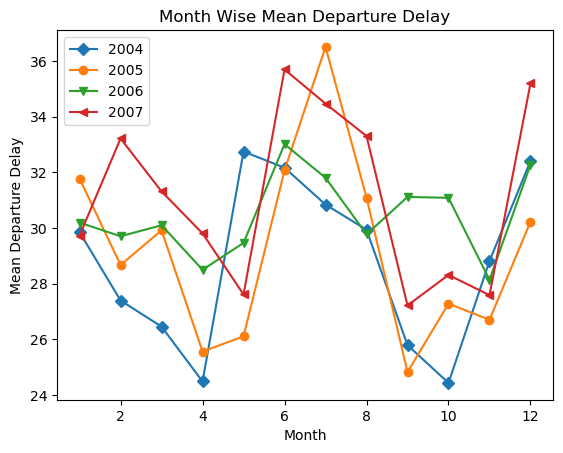

In [29]:
collected['month'] = collected['month'].astype(int)
collected = collected.sort_values(by=['month'], ascending=True)
print(collected)
monthlist = list(collected['month'])
delay_2004 = list(collected['2004'])
delay_2005 = list(collected['2005'])
delay_2006 = list(collected['2006'])
delay_2007 = list(collected['2007'])

plt.plot(monthlist, delay_2004,label='2004',marker = 'D')
plt.plot(monthlist, delay_2005,label='2005',marker = 'o')
plt.plot(monthlist, delay_2006,label='2006',marker = 'v')
plt.plot(monthlist, delay_2007,label='2007',marker = '<')

plt.ylabel('Mean Departure Delay')
plt.xlabel('Month')
plt.title('Month Wise Mean Departure Delay')
plt.legend()
plt.savefig('delayTrend.png', bbox_inches='tight')
plt.show()

## Monthwise Arrival Delay

In [30]:
monthwiseArrDelay = Flight_Spark_frame.withColumn("ArrDelay", F.when(col("ArrDelay") >0,col('ArrDelay'))) \
                    .groupBy("Month").pivot("Year").agg(F.avg('ArrDelay'))

## Transform to pandas for plotting 

In [31]:
collected = monthwiseArrDelay.select('month', '2004','2005','2006','2007').toPandas()

## Plot the arrival trend in four different years

    month       2004       2005       2006       2007
7       1  28.534699  30.916874  28.441847  30.516488
11      2  25.783051  26.773322  28.637786  34.166048
2       3  24.545130  28.338166  28.928957  32.365418
9       4  22.383505  23.053556  27.267845  30.420432
4       5  31.400010  23.705008  28.194171  28.222023
5       6  31.944669  31.387476  33.745502  37.878617
0       7  30.532900  36.819334  33.765102  36.004844
3       8  29.015292  30.188272  30.683293  34.677752
6       9  23.426948  22.916640  30.716579  26.815686
8      10  22.559104  24.854837  31.258670  27.994961
1      11  26.645137  25.618318  28.922220  27.155268
10     12  31.243305  30.004571  33.215441  36.506249


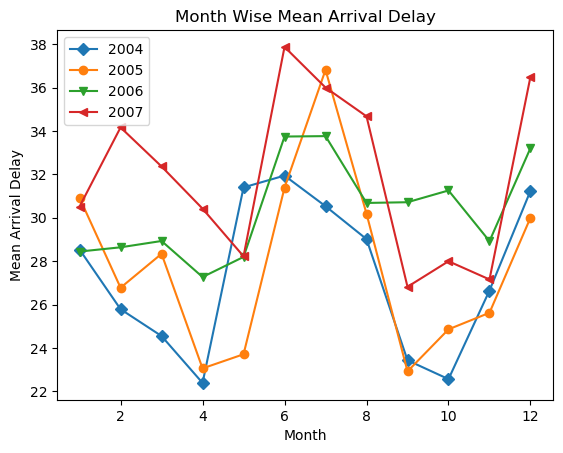

In [32]:
collected['month'] = collected['month'].astype(int)
collected = collected.sort_values(by=['month'], ascending=True)
print(collected)
monthlist = list(collected['month'])
delay_2004 = list(collected['2004'])
delay_2005 = list(collected['2005'])
delay_2006 = list(collected['2006'])
delay_2007 = list(collected['2007'])

plt.plot(monthlist, delay_2004,label='2004',marker = 'D')
plt.plot(monthlist, delay_2005,label='2005',marker = 'o')
plt.plot(monthlist, delay_2006,label='2006',marker = 'v')
plt.plot(monthlist, delay_2007,label='2007',marker = '<')

plt.ylabel('Mean Arrival Delay')
plt.xlabel('Month')
plt.title('Month Wise Mean Arrival Delay')
plt.legend()
plt.savefig('arrival.png', bbox_inches='tight')
plt.show()